# Coding a Neural Network From Scratch
Many of us have a functional idea about neural network and how they work. I've even studied this particular term multiple times and eveytime I convince myself that I know what I'm talking about. Human brain is funny that way, it takes the path of least resistence and convinces us that we know something when we don't. Though I've used neural networks multiple times for tasks ranging from binary classification to natural language processing, I've never really implemented them from scratch and if you're like me, then your understanding of neural networks ends at Y = WX + b.

In this article I'll implment a neural network from scratch going over different concepts like derivatives, gradient descent and backward propagation of gradients.
I would also like to mention that this article is inspired by Anderj Karapthy's brilliant [lecture series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) on youtube and I would be making use of some of the code mentioned in that video.

## Introduction

*Feel free to skip to next section as the introduction section covers the theory of neural networks and not the implementaion.*

Neural networks are a type of machine models which are inspired by the structure of human brain. Similar to our brain, Neural networks are made up of Neurons that work together to accomplish whole variety of tasks. The diagram below shows the neuron:

![Neuron from Neural network](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

Where :
- `output`: This is the final value or activation of the neuron.
- `activation_function`: This is a mathematical function that determines whether the neuron should fire or not based on its input.
- `weighted_sum`: It is the sum of the products of the input values and their corresponding weights.
- `bias`: A bias term is added to the weighted sum to provide the neuron with some flexibility in its activation.

The weighted sum is calculated as follows: `weighted_sum = (w1 * x1) + (w2 * x2) + ... + (wn * xn)`
Where:
- `w1, w2, ..., wn`: These are the weights associated with each input.
- `x1, x2, ..., xn`: These are the input values.

The activation function can be any non-linear function, such as the sigmoid, ReLU (Rectified Linear Unit), or softmax function, depending on the type of neuron and the task at hand.

The role of the activation function is to introduce non-linearity into the neuron's output, allowing it to learn complex patterns and relationships in the data.

In summary, a single neuron in a neural network takes input values, applies weights to them, sums them up with a bias term, and then passes the result through an activation function to produce an output. This output is then used as input for subsequent layers or neurons in the neural network, enabling the network to learn and make predictions for various tasks.

Now, with all the theory out of the way, let's implement a neuron. Starting with derivatives.







## Getting rid of the imports early on in the process

In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivatives

Before moving to neuron and neural network, let's briefly go over the functions and their derivatives. As all of us have learnt in school that
A derivative of a function with respect to a variable shows the rate of change of the function with respect to that variable.

What does this means for a function say `f(x) = 5x - 9`?

`f'(x)=5` i.e the function `f(x)` increases by a factor of 5 for 1 unit change in x. We can also calculate this value by nudging x by an infinitisimal value `h` and observe how `f(x)` changes.
i.e

```
f(x) = 5x - 9
f(x+h) = 5(x+h) - 9
f`(x) = (f(x+h) - f(x))/(x+h - x) = 5 --> This is also referred to as rise over run or slope
```

### Multi variate functions
For a multi variate functions such as `d = a*b + c`, the rate of change is different for different variable.

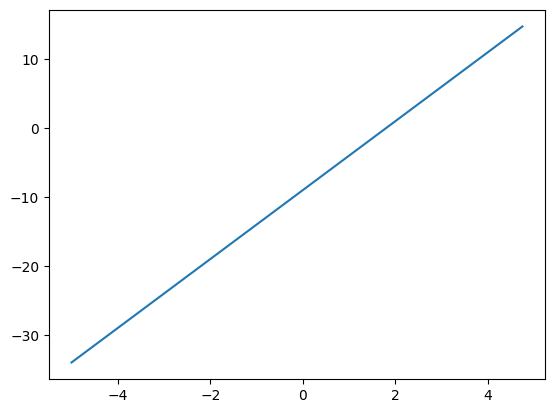

In [90]:
def f(x):
  return 5*x - 9

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

## Implementation of a Value in neural network
Pytorch makes use of `Tensors` for computation, to replicate the functionality we'll write our own implementation `Value`

In [91]:
class Value:
    def __init__(self, data, label=''):
        self.data = data
        self.label = label
        self.grad = 0.0 # We'll go over this field in detail later on
    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"

In [92]:
'''
Let's make use of a multi-variate equation and write it using the Value class defined above
a = 2.0
b = -3.0
c = 10.0
e = a * b
d = e + c
f = -2.0
l = d * f
'''
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b


TypeError: unsupported operand type(s) for *: 'Value' and 'Value'

In [93]:
''' 
The error above shows that * isn't defined for Value type. We'll need to modify the Value type to support + and * operations. 
We'll also add an op field that shows how the Value was created. Since we are working with neural network, we'll need to keep track of the childrens of a node.
So we'll add a _prev field to the Value type
'''
class Value:
    def __init__(self, data, _children=(),   _op='', label=''):
        self.data = data
        self.label = label
        self._op = _op
        self._prev = set(_children)
        self.grad = 0
        
    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [94]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value=(data=-8.0, label=L)

For visualizing the network we'll make use of `graphviz`. The code below if directly referenced from https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd.


In [95]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

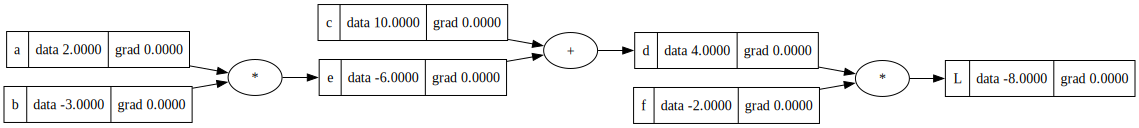

In [96]:
''' 
Plotting the variable L to layout the network. The _op nodes are just rendered to show the parent/child relation between nodes
'''
draw_dot(L)

In [97]:
'''
Manually computing gradiant moving backwards from L
'''

L.grad = 1.0 # Base case as rate of change of L wrt to L is 1
''' 
We know that L = d*f
so dL/de (gradiant of L wrt to f or rate of change of L wrt to f) = d
similarly dL/dd will be f
'''

d.grad = f.data
f.grad = d.data

''' 
Since d = e + c, to find out dL/dd (Rate of change of L wrt to d) we'll make use of the chain rule i.e
dL/de = (dL/dd) * (dd/de) = (dL/dd) * 1.0
similarly dL/dc = dL/dd * 1.0
'''
e.grad =  d.grad
c.grad = d.grad

''' 
e = a * b
So following the chain rule again
dL/da = (dL/de) * (de/da) = (dL/de) * b
dL/db = (dL/de) * (de/db) = (dL/de) * a
'''
a.grad = e.grad * b.data
b.grad = e.grad * a.data

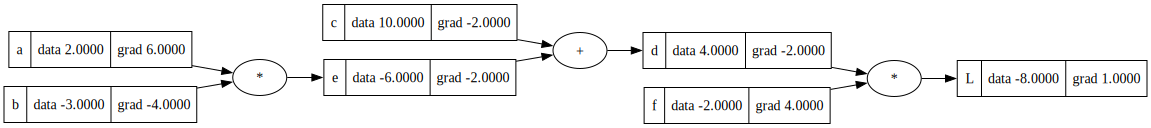

In [98]:
''' 
Plotting the variable L to layout the network.
'''
draw_dot(L)

From the diagram above, we can make a simple observation that `+` nodes transfer gradiants from child node to parent nodes, example gradiant of `e` and `c` are same as that of `d`. Now that we have established the concepts of gradiants. Let's move towards expression representing a Neuron.

In [99]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


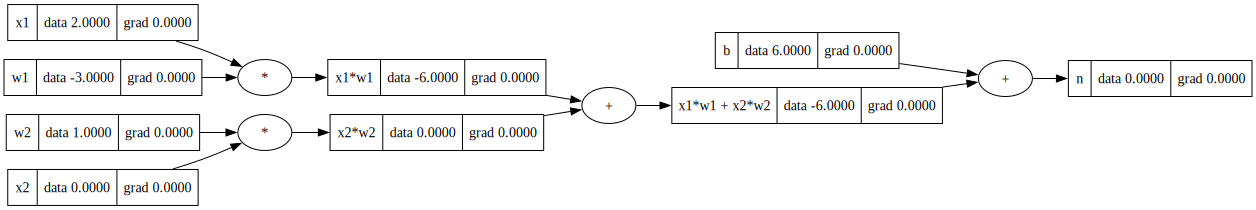

In [102]:
draw_dot(n)

### Activation function
Neurons also make use of something called a activation function. Activation functions introduce non-linearity into the neural network, allowing it to model complex relationships and learn from data. For the purpose of this article, we'll use `tanh` as our activation function. The tanh function squashes the net input, but it maps it to a range between -1 and 1. It is often used in hidden layers of neural networks.


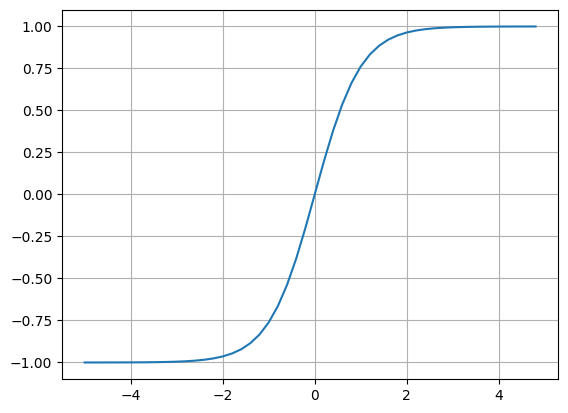

In [103]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

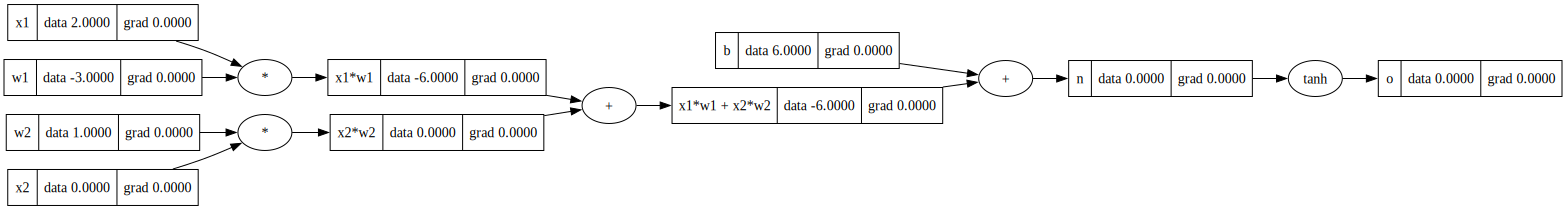

In [104]:
'''
We'll pass n through an activation function tanh but before that we'll need to add tanh to the Value type since tanh doesn't understand Value type.
'''

def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

# Attach the instance method to the class
Value.tanh = tanh

o = n.tanh(); o.label = 'o'
draw_dot(o)

## Backpropagation

Inorder to calculate the gradiant of each node, it'll be insanity to do that manually, as the size of the network grows. We'd like to create method `_backward` that does that for each node. Since calculating gradiant requires differentiating the function, we'd have to implement that in `_backward` method. Here's what that would look like for each operation in Value type

- `add` method

```
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
```

- `mul` method

```
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
```
    
- `tanh` method
```
def _backward():
      self.grad += (1 - t**2) * out.grad

```

In [105]:
'''
Updating Value to include _backward function for each operation method
'''

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

In [106]:
'''Reinitializing the values to reflect new class properties '''
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

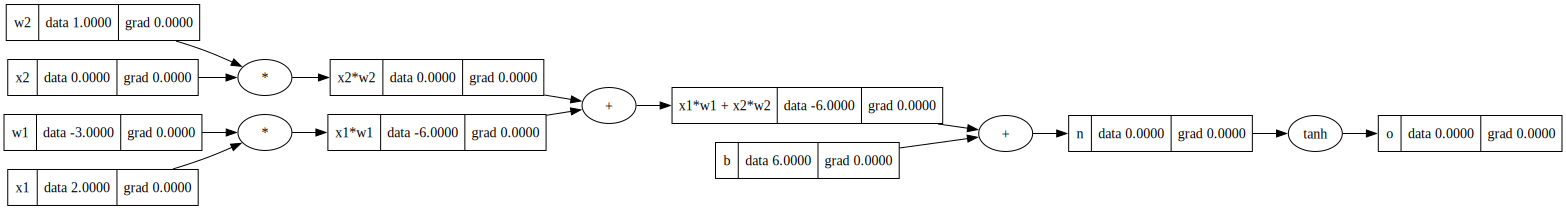

In [107]:
draw_dot(o)

In [108]:
o.grad = 1.0 # base case
'''
Calling backward on o will change gradiant of n
'''
o._backward()

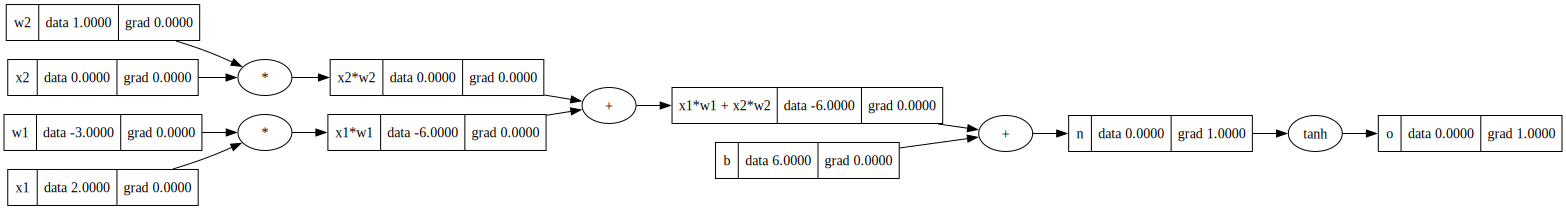

In [109]:
draw_dot(o)

In [110]:
'''
Calling backward on n will change gradiant of x1w1 + x2w2 and b nodes
'''
n._backward()

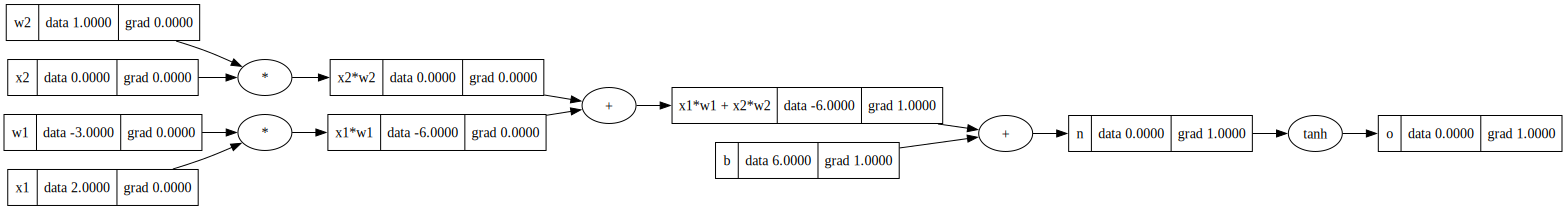

In [111]:
draw_dot(o)

In [112]:
'''
Calling backward on x1w1x2w2 will change gradiant of x2w2 and x1w1 
'''
x1w1x2w2._backward()

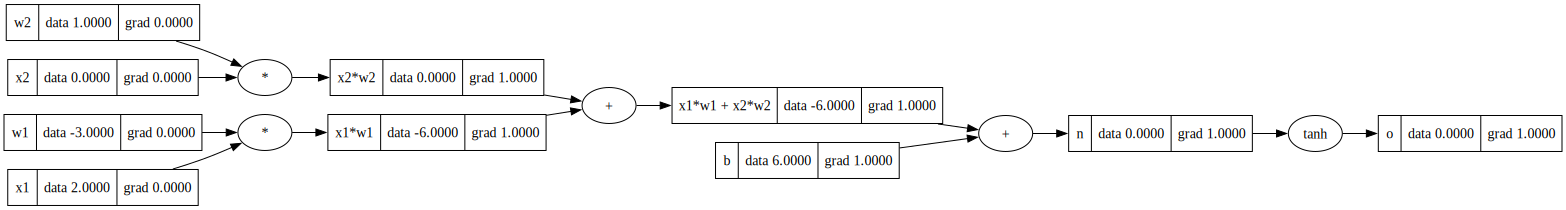

In [113]:
draw_dot(o)

In [114]:
'''
Calling backward on x1w1 and x1w1 will change gradiant of x1, x2, w1 and w2
'''
x1w1._backward()
x2w2._backward()

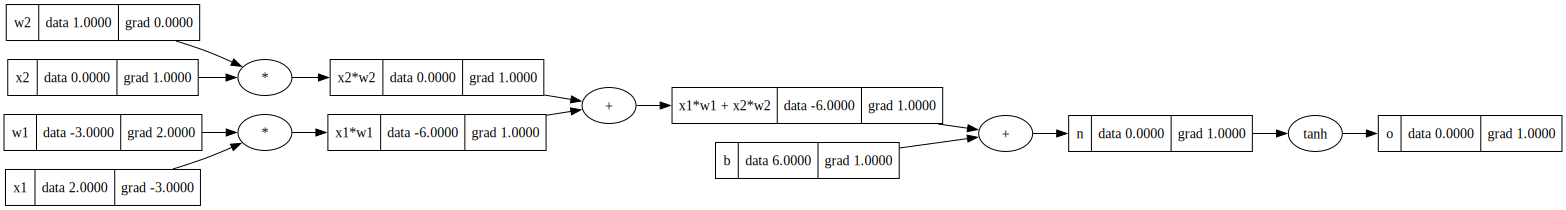

In [115]:
draw_dot(o)

In [116]:
'''
A better way to do this would be to have a method that executes backward method for all children starting from current node. 
This would require getting the order of nodes such that current node is the first one and all it's children are processed after it. This is what topological sort provides us with
'''

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6),
 Value(data=0.0),
 Value(data=0.0)]

In [117]:
'''
Using the above approach we can write a method in Value class that class _backward method for each of the childres of a class
'''
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    
    self.grad = 1.0 # Replicating the base case
    for node in reversed(topo):
      node._backward()

# Attach the instance method to the class
Value.backward = backward

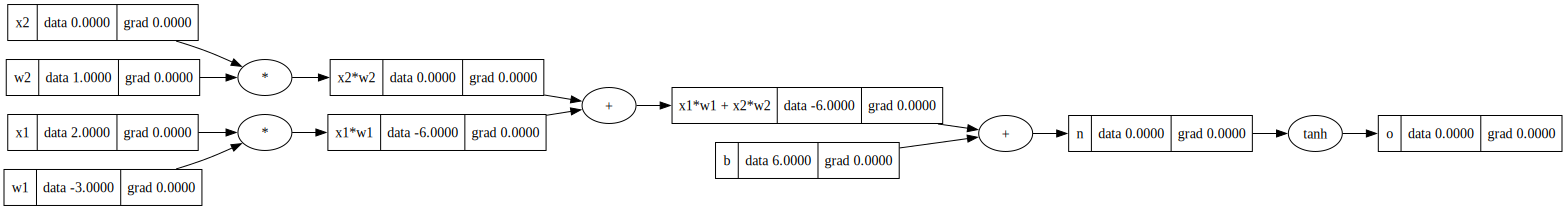

In [118]:
'''Reinitializing the values to reflect new class properties '''
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [119]:
o.backward()

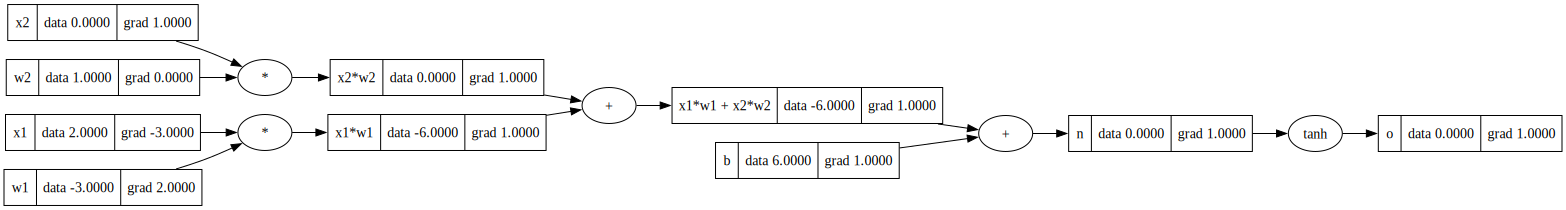

In [120]:
draw_dot(o)

In [121]:
'''
We can verify our implementation using pytorch library
'''
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # requires_grad forces the tensor to be used in calculations of gradients
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.0
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


## Coding a neural network
In the sections above we have created a `Value`` class that allows us to create multi variate equations and using backpropagation allows us to calculate gradients. For creating a neural network we'd create the following classes that would make use of `Value` class
- `Neuron` - Depicting a single neuron in the network
- `Layer`- Depciting a single layer in the neural network that would contain multiple `Neuron`s
- `MLP`- Depicting a Multi Layer Perceptron or a neural network with multiple `Layer`s of `Neuron`s

![Neuron from Neural network](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

The diagram above shows the structure of a Neuron with weights(Wi), bias(b) and input(xi) as the `inputs` and a single output passed through activation function `tanh` in our case

The weighted sum is calculated as follows: `weighted_sum = (w1 * x1) + (w2 * x2) + ... + (wn * xn)`
Where:
- `w1, w2, ..., wn`: These are the weights associated with each input.
- `x1, x2, ..., xn`: These are the input values.

In [122]:
import random
class Neuron:
    def __init__(self, ninp):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(ninp)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        out = sum([ wi*xi for wi, xi in zip(self.w, x)]) + self.b
        res = out.tanh()
        return res
    
    def parameters(self): # This function would be used later on while training the network
        return self.w + [self.b]

In [123]:
x = [1.0, 2.0, 3.0 ]
n = Neuron(3)
n(x)

AttributeError: 'float' object has no attribute 'data'

In [124]:
'''
The error above is the result of multiplying Value type with a float type. To support such operations we'll modify Value with a few more methods
'''
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [125]:
'''
Trying out the above operation again
'''
x = [1.0, 2.0, 3.0 ]
n = Neuron(3)
n(x)

Value(data=-0.5181071586116809)

In [126]:
# Next we'll define a layer in neural network
class Layer:
    def __init__(self, ninp, nneurons): # ninp is the number of inputs for each neuron in the layer
        self.neurons = [Neuron(ninp) for _ in range(nneurons)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [127]:
'''
Input x is passed through each neuron of layer l, hence 4 values output from the layer
'''
x = [1.0, 2.0, 3.0 ]
l = Layer(3, 4)
l(x) 

[Value(data=0.971182517031463),
 Value(data=-0.9790568300306317),
 Value(data=-0.4857385699176223),
 Value(data=-0.9636928832453497)]

In [128]:
# Next we'll define a MLP class that's be our neural network
class MLP:
    def __init__(self, nin, nouts): # nin is the number of inputs for the first layer and nouts is an [] for output in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]    

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In the example we create the following MPL 
First layer: 3 inputs
Middle layers: 4 and 4 outputs
Output layer: 1

![MLP](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)


In [129]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3286322706370602)

## Creating a binary classifier

In [130]:
'''
For the xs as inputs we have a target ys which are the true predictions. We'll create an MLP with the same structure as we saw above
'''
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [131]:
'''
Each x in xs would be passed to MLP, resulting in ypred, this is termed as forward pass
'''
ypred = [n(x) for x in xs]
ypred


[Value(data=-0.9605353699041816),
 Value(data=-0.9652866142967272),
 Value(data=0.26960003457444665),
 Value(data=-0.9511958636250315)]

### Loss
We see above that `ypredi` is different than `yi`. The difference between the values is termed as `loss`. We can use different methods to calculate `loss`.
In this example we'll make use of `Squared error`

In [132]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=9.26395350181118)

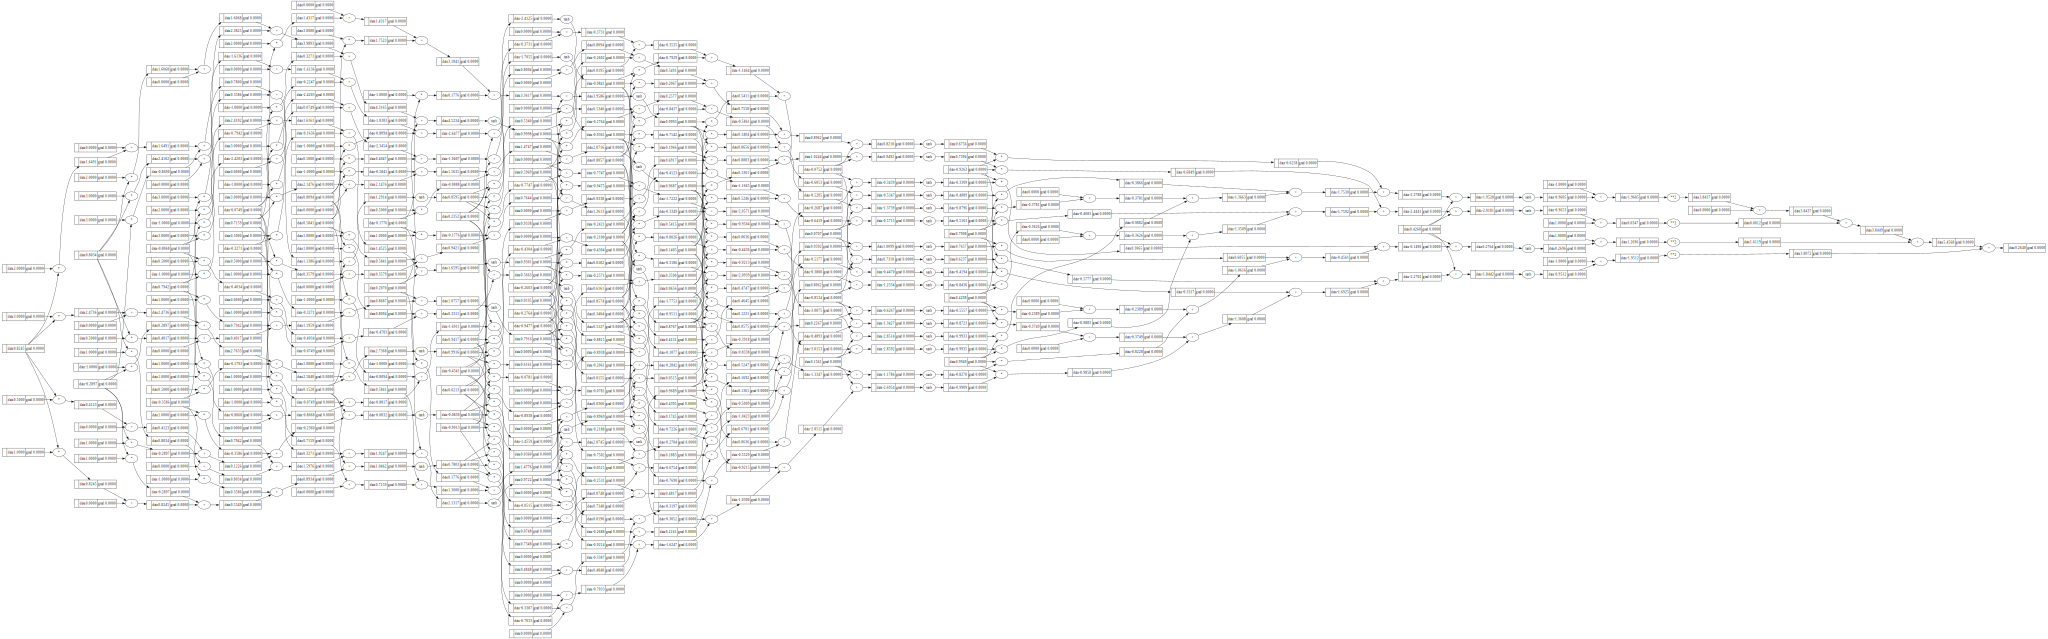

In [133]:
draw_dot(loss)

In [134]:
'''
Next step is to perform bacward pass that uses back propagation to calculate gradiant.
'''
loss.backward()

In [135]:
'''
Once we've calculated the gradiant corresponding to each parameter of the MLP, we'll modify the value of each parameter by a small value also known as learning rate

'''
for p in n.parameters():
    p.data += -0.1 * p.grad

In [136]:
'''
After updating the values, we can check the loss again, this time loss should be reduced
'''
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.829761457067251)

## Training loop
We can the above steps into a training loop

In [137]:
'''
Resetting the values
'''
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1])

In [138]:
for k in range(50):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.6406853121192033
1 3.610944134843126
2 3.741912394115651
3 3.2018009544051136
4 3.2524598245980503
5 1.9728216636593452
6 1.3173214047883315
7 1.0735765629752656
8 0.8890437353493715
9 0.11522009736067115
10 0.05081752438719958
11 0.03672318278028023
12 0.02979416308450841
13 0.02556184631434586
14 0.022653024581680118
15 0.02049638823502594
16 0.01881087828912575
17 0.017442066784978914
18 0.01629801693027828
19 0.015320499407445488
20 0.014470748984735923
21 0.013721869837929553
22 0.013054538143998672
23 0.012454448840696034
24 0.01191073501042354
25 0.011414954174232338
26 0.010960417756148979
27 0.010541735226885831
28 0.010154496500154066
29 0.009795045700014122
30 0.009460316742793573
31 0.009147711635699132
32 0.008855008873882249
33 0.008580293427428378
34 0.008321902472546286
35 0.00807838278062741
36 0.007848456862487212
37 0.007630995774834821
38 0.007424997058651014
39 0.007229566675831996
40 0.007043904093967112
41 0.006867289874369098
42 0.006699075268871989
43 0.006